<div style="padding: 30px 60px; border: 5px skyblue solid; border-radius: 30px; max-width: 600px; font-size: 2rem; line-height: 3rem; color: black; font-family: sans-serif;">

  <div style="font-size: 1.5rem; font-weight: 200;">[CM3070] Final Project - BSc CS University of London</div>
  <div style="font-size: 1.5rem; font-weight: 500;">Deep Learning on Satellite Imagery</div>
  <div style="font-size: 2rem; color: dodgerblue; font-weight: bold;">by Arjun Bajaj</div>
</div>

# Exploring many model architectures on the EuroSAT dataset

This notebook explores many different kinds of model architectures. It uses techniques described in Deep Learning with Python by François Chollet, for image classification.

First, a model with only `Dense` layers is built to show that it is not an effective approach. After that, Convolutional Neural Networks are explored with `Conv2D` and `SeparableConv2D` layers. Data Augmentation is also explored in some models. Large models cannot be deployed to microcontrollers, however getting high accuracy in larger models first helps in building better smaller models.

The goal of this notebook is to solely experiment with what's possible with the dataset. The next notebook implements building and regularizing a few small models which are capable of running on microcontrollers.

Each model is encapsulated in its own function to avoid scope leak. All models are trained for `20` epochs. The final accuracy printed is always the highest validation accuracy. After the model is trained, the model is loaded again from disk and evaluated on the validation dataset. The test dataset is not used at all in this notebook, as recommended in the Deep Learning with Python book in the _Universal Workflow of Deep Learning_, as evaluating accuracy on test dataset from the get-go can lead to leaking biases` in the models.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from core import load_eurosat, compile_and_train_model

In [3]:
dataset = load_eurosat()

Found 21600 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.


# Simple Fully-Connected Network

This model uses only `Dense` layers to do image classification. It reaches a higher accuracy than the baseline established in the previous notebook, however, it also shows that `Dense` layers are not suitable for image classification. This model reaches an accuracy of `48.74%`.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 512)               6291968   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 6,297,098
Trainable params: 6,297,098
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
338/338 [==============================]

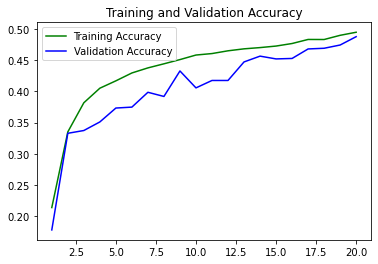

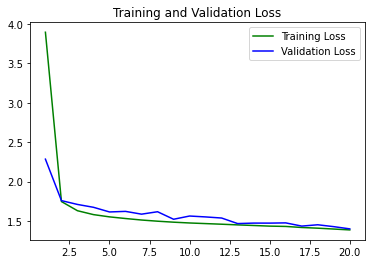

43/43 [==============================] - 0s 8ms/step - loss: 1.3995 - accuracy: 0.4874

Trained for 20 epochs in 2m8s.
Highest Validation Accuracy: 48.74%


In [8]:
def simple_densenet():
  inputs = keras.Input(shape=(64, 64, 3))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Flatten()(x)
  x = layers.Dense(512, activation='relu')(x)
  outputs = layers.Dense(10, activation='softmax')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  compile_and_train_model(model, 'eurosat_densenet', dataset, epochs=20)

simple_densenet()

# Basic ConvNet with `3 Conv2D` layers

This is the first Convolutional Neural Network (ConvNet) implemented for the EuroSAT dataset. The model consists of `3 Conv2D` layers of increasing number of filters. The model reaches an accuracy of `78.48%` with `94k+` trainable parameters. It has been experimentally established that the Raspberry Pi Pico Microcontroller cannot run such large models. However, the models below are larger to achieve overfitting and higher accuracy.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                         

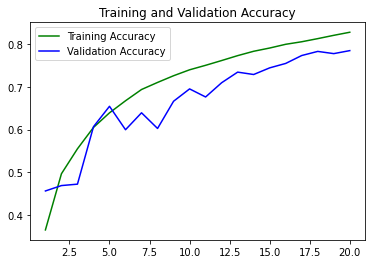

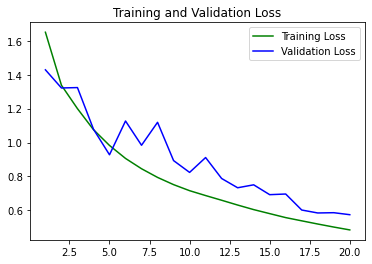

43/43 [==============================] - 1s 14ms/step - loss: 0.5745 - accuracy: 0.7848

Trained for 20 epochs in 4m2s.
Highest Validation Accuracy: 78.48%


In [4]:
def convnet_v1():
  inputs = keras.Input(shape=(64, 64, 3))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  compile_and_train_model(model, "convnet_v1", dataset, epochs=20)

convnet_v1()

# ConvNet with `4 Conv2D` layers

This model adds another `Conv2D` layer, totalling `4`, with the largest one having `256` filters. The model has `390k+` trainable parameters and achieves an accuracy of `87.59%`, demonstrating that the EuroSAT dataset can be effectively classified using Deep Learning techniques.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                       

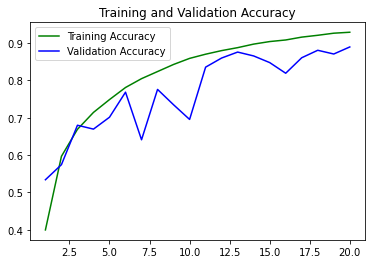

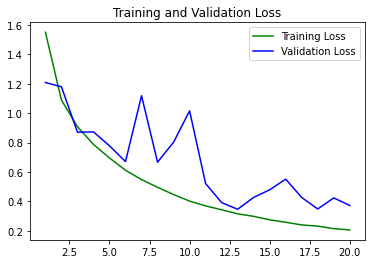

43/43 [==============================] - 1s 17ms/step - loss: 0.3459 - accuracy: 0.8759

Trained for 20 epochs in 4m22s.
Highest Validation Accuracy: 87.59%


In [5]:
def convnet_v2():
  inputs = keras.Input(shape=(64, 64, 3))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  compile_and_train_model(model, "convnet_v2", dataset, epochs=20)

convnet_v2()

# ConvNet with `4 Conv2D` layers and Data Augmentation

This model also adds Data Augmentation layers to the mix. Data Augmentation should improve model accuracy as the model sees a variation of each image on every epoch. Adding Data Augmentation, counter-intuitively, decreases the accuracy from `87.59%` to `83.44%`. Perhaps the overall accuracy would improve if trained for many more epochs, so it will be explored later.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_4 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 64)        18496     
                                                           

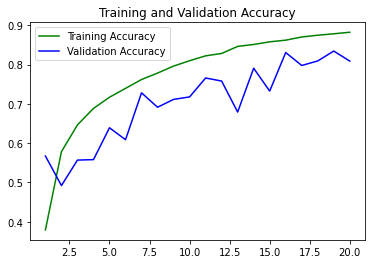

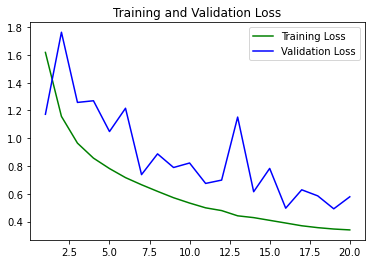

43/43 [==============================] - 1s 14ms/step - loss: 0.4917 - accuracy: 0.8344

Trained for 20 epochs in 6m24s.
Highest Validation Accuracy: 83.44%


In [8]:
with tf.device('/cpu:0'):
  data_augmentation = keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ])

def convnet_v3():
  inputs = keras.Input(shape=(64, 64, 3))

  # The Apple M1 GPU Driver doesn't implement the
  # TensorFlow Op required for Data Augmentation
  with tf.device('/CPU:0'):
    x = data_augmentation(inputs)

  x = layers.Rescaling(1./255)(x)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  compile_and_train_model(model, "convnet_v3", dataset, epochs=20)

convnet_v3()

# ConvNet with Batch Normalization

This model implements the `BatchNormalization` layer. The model does significantly worse than the previous models, at an accuracy of `69.3%`.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        864       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                           

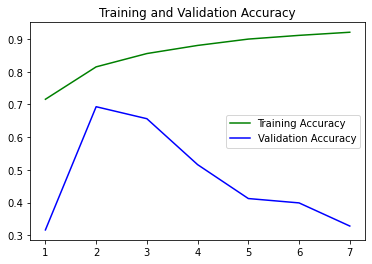

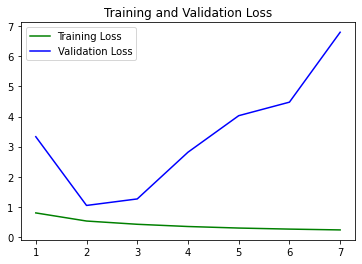

43/43 [==============================] - 1s 23ms/step - loss: 1.0457 - accuracy: 0.6930

Trained for 7 epochs (stopped early) in 2m30s.
Highest Validation Accuracy: 69.30%


In [4]:
def convnet_v4():
  inputs = keras.Input(shape=(64, 64, 3))
  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  
  x = layers.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  
  x = layers.Conv2D(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  
  x = layers.Conv2D(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.GlobalAveragePooling2D()(x)
  
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()

  compile_and_train_model(model, "convnet_v4", dataset, epochs=20)

convnet_v4()

# ConvNet with Batch Normalization and Residuals

This model implements residuals along with batch normalization, however, the largest `Conv2D` layer contains only `128` filters compared to `256` filters in the previous models. This model performs better than just using Batch Normalization, but still gives an accuracy of `83.41%` after training for 10 epochs due to Early Stopping. It is possible that this architecture gives better results when trained for much longer. This will be explored in the next notebook. However, now it is important to focus on smaller models which can be run on a microcontroller.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 64, 64, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 64, 32)   864         ['rescaling_1[0][0]']            
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 64, 64, 32)  128         ['conv2d_4[0][0]']               
 rmalization)                                                                               

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


338/338 [==============================] - 28s 83ms/step - loss: 0.5629 - accuracy: 0.8018 - val_loss: 1.2488 - val_accuracy: 0.6048
Epoch 3/20
338/338 [==============================] - 28s 84ms/step - loss: 0.4350 - accuracy: 0.8509 - val_loss: 1.0578 - val_accuracy: 0.7074
Epoch 4/20
338/338 [==============================] - 29s 85ms/step - loss: 0.3571 - accuracy: 0.8784 - val_loss: 1.1852 - val_accuracy: 0.7011
Epoch 5/20
338/338 [==============================] - 28s 82ms/step - loss: 0.3038 - accuracy: 0.8966 - val_loss: 0.5982 - val_accuracy: 0.8341
Epoch 6/20
338/338 [==============================] - 28s 84ms/step - loss: 0.2678 - accuracy: 0.9078 - val_loss: 1.3385 - val_accuracy: 0.7219
Epoch 7/20
338/338 [==============================] - 28s 84ms/step - loss: 0.2401 - accuracy: 0.9166 - val_loss: 1.2881 - val_accuracy: 0.7400
Epoch 8/20
338/338 [==============================] - 29s 84ms/step - loss: 0.2168 - accuracy: 0.9243 - val_loss: 1.2018 - val_accuracy: 0.7352
Epo

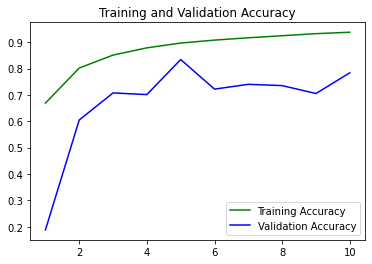

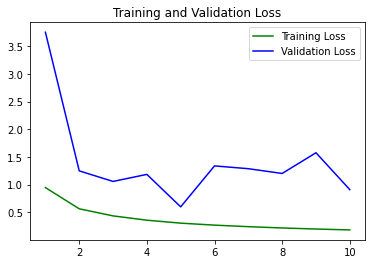

43/43 [==============================] - 1s 19ms/step - loss: 0.5982 - accuracy: 0.8341

Trained for 10 epochs (stopped early) in 4m41s.
Highest Validation Accuracy: 83.41%


In [5]:
def convnet_v5():
  inputs = keras.Input(shape=(64, 64, 3))
  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(filters=32, kernel_size=3, padding="same", use_bias=False)(x)

  for size in [32, 64, 128]:
    residual = x
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(10, activation="softmax")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  compile_and_train_model(model, "convnet_v5", dataset, epochs=20)

convnet_v5()

# Small ConvNet

This model is a small ConvNet with `4 Conv2D` layers, but each layer only has 32 filters. The model only has just under `29k` trainable parameters, making it suitable to deploy on the Pico with its tiny `256kb` RAM. The model in this configuration only achieves an accuracy of `79.52%`. The next notebook shows how this model and other similar architectures can be improved.

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                      

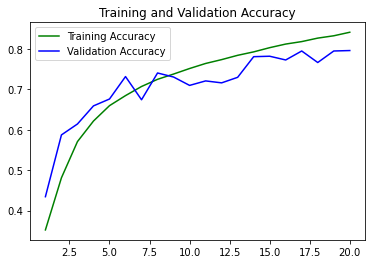

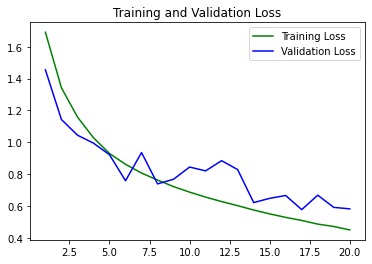

43/43 [==============================] - 1s 13ms/step - loss: 0.5774 - accuracy: 0.7952

Trained for 20 epochs in 2m43s.
Highest Validation Accuracy: 79.52%


In [8]:
def convnet_v6():
  inputs = keras.Input(shape=(64, 64, 3))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
  x = layers.GlobalMaxPooling2D()(x)
  outputs = layers.Dense(10, activation="softmax")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.summary()

  compile_and_train_model(model, "convnet_v6", dataset, epochs=20, early_stopping=False)

convnet_v6()

# Conclusion

This notebook demonstrates that effective Image Classification models can be built on the EuroSAT dataset. The models in this notebook have achieved high accuracies, along with overfitting. Many architectures are demonstrated from large to small models. The next notebook focuses on building models which can be deployed to microcontrollers. That means there is a stringent requirement on the number of trainable parameters.

----